# Spatial domain refinement

This tutorial demonstrates how to perform spatial domain refinement using SpaHDmap, focusing on a specific region of interest within your spatial transcriptomics data.

We will use the IHC stained mouse brain dataset as an example, refining a region corresponding to a specific spatial domain.

## 1. Import Necessary Libraries

In [2]:
import torch
import numpy as np
import scanpy as sc

import SpaHDmap as hdmap

/home/qk/anaconda3/lib/python3.11/importlib/__init__.py:126: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  return _bootstrap._gcd_import(name[level:], package, level)


## 2. Set Parameters and Paths

Set the parameters and file paths for analysis.

In [3]:
rank = 20
seed = 123
verbose = True

np.random.seed(seed)
torch.manual_seed(seed)

root_path = '../experiments/'
project = 'MBC01'
results_path = f'{root_path}/{project}/Results_Rank{rank}/'
results_path_refine = f'{root_path}/{project}/Refine_Emb2/'

## 3. Load stData and Prepare for Refinement

We will load the saved results from the previous tutorial, which contains the IHC stained mouse brain dataset. This dataset is used to demonstrate the spatial domain refinement process.

*** Loading saved STData from ../experiments//MBC01/Results_Rank20/mouse_cortex.st ***
*** Preparing the tissue splits and creating pseudo spots... ***
*** Using GPU ***
*** Visualizing and saving the embeddings of SpaHDmap... ***


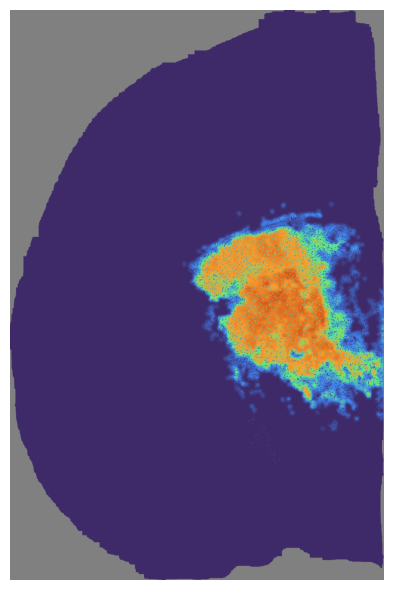

In [4]:
# Load the saved SpaHDmap results
mouse_cortex = hdmap.prepare_stdata(st_path=(results_path + 'mouse_cortex.st'))

# Initialize the Mapper with the loaded data
mapper = hdmap.Mapper(mouse_cortex, results_path=results_path, rank=rank, verbose=verbose)

# Visualize the SpaHDmap score
mapper.visualize(mouse_cortex, use_score='SpaHDmap', index=2)

Then we extract the spots with high SpaHDmap scores, which will be used for refinement.

In [5]:
# Extract spots with high SpaHDmap scores
high_score_spots = mapper.extract_spots(index=2, use_score='SpaHDmap_spot', threshold=0.05)

# Reload the original data to refine
section_id = 'V1_Adult_Mouse_Brain_Coronal_Section_2'
adata = sc.datasets.visium_sge(section_id, include_hires_tiff=True)
adata_refine = adata[high_score_spots, :]

image_path = adata.uns["spatial"][section_id]["metadata"]["source_image_path"]

mouse_cortex_refine = hdmap.prepare_stdata(adata=adata_refine, section_name='mouse_cortex', image_path=image_path)

*** Extracting high-score spots for Embedding_2 in section mouse_cortex... ***
Found 408 spots (out of 2807, 14.54%) above threshold 0.05


/tmp/ipykernel_219685/2256404011.py:6: FutureWarning: Use `squidpy.datasets.visium` instead.
  adata = sc.datasets.visium_sge(section_id, include_hires_tiff=True)
/home/qk/anaconda3/lib/python3.11/site-packages/scanpy/datasets/_datasets.py:555: FutureWarning: Use `squidpy.read.visium` instead.
  return read_visium(sample_dir, source_image_path=source_image_path)
/home/qk/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/qk/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


*** Reading and preparing AnnData for section mouse_cortex ***
Spot radius found in AnnData: 89
Pre-processing gene expression data for 408 spots and 32285 genes.


/home/qk/projects/DeepFuseNMF/SpaHDmap/data/data_util.py:403: ImplicitModificationWarning: Setting element `.obsm['spatial']` of view, initializing view as actual.
  adata.obsm['spatial'] = adata.obsm['spatial'][:, ::-1]
/home/qk/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Swapping x and y coordinates.
Processing image, seems to be Immunofluorescence image.


## 4. Run SpaHDmap Analysis for refined section

We define a function to generate a mask for the refined section, which covers the spots of interest.

In [6]:
def get_mask(section):
    mask = np.zeros_like(section.mask, dtype=np.bool_)
    for (row, col) in section.spot_coord:
        row, col = round(row - section.row_range[0]), round(col - section.col_range[0])
        row_range = np.arange(max(row - 2*section.radius, 0), min(row + 2*section.radius + 1, mask.shape[0]))
        col_range = np.arange(max(col - 2*section.radius, 0), min(col + 2*section.radius + 1, mask.shape[1]))
        mask[np.ix_(row_range, col_range)] = 1

    return mask

mouse_cortex_refine.mask = get_mask(mouse_cortex_refine)

The mask is applied to the refined section to focus on the spots of interest.

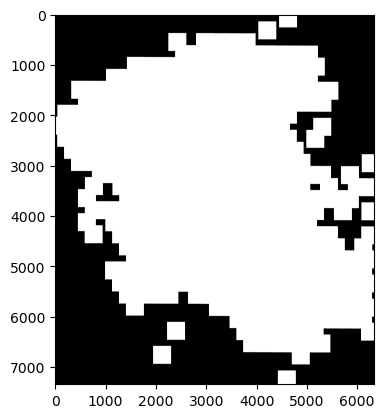

In [7]:
import matplotlib.pyplot as plt
plt.imshow(mouse_cortex_refine.mask*255, cmap='gray')
plt.show()

In [8]:
mapper = hdmap.Mapper(mouse_cortex_refine, results_path=results_path_refine, rank=10, verbose=True)

mapper.run_SpaHDmap()

*** Preparing the tissue splits and creating pseudo spots... ***
*** Single section detected. Using its 10000 genes. ***
*** The split size is set to 256 pixels. ***
For section mouse_cortex, divide the tissue into 824 sub-tissues, and create 2500 pseudo spots.
*** Using GPU ***
Step 1: Run NMF
*** Performing NMF... ***
*** Visualizing and saving the embeddings of NMF... ***
Step 2: Pre-train the SpaHDmap model
*** Pre-trained model found at ../experiments//MBC01/Refine_Emb2//models//pretrained_model.pth, loading... ***
Step 3: Train the GCN model
*** Performing GCN... ***
*** Training GCN for mouse_cortex... ***
[Iter: 200 / 5000], Loss: 0.017658, Learning rate: 4.985215e-03
[Iter: 400 / 5000], Loss: 0.010385, Learning rate: 4.941093e-03
[Iter: 600 / 5000], Loss: 0.008443, Learning rate: 4.868331e-03
[Iter: 800 / 5000], Loss: 0.007181, Learning rate: 4.768075e-03
[Iter: 1000 / 5000], Loss: 0.006268, Learning rate: 4.641907e-03
[Iter: 1200 / 5000], Loss: 0.005731, Learning rate: 4.4918

Now, we can visualize the refined SpaHDmap scores, where the index 1 corresponds to the Thalamus, sensory-motor cortex related region (DORsm) and index 7 corresponds to the Thalamus, polymodal association cortex related region (DORpm)

*** Visualizing and saving the embeddings of SpaHDmap... ***


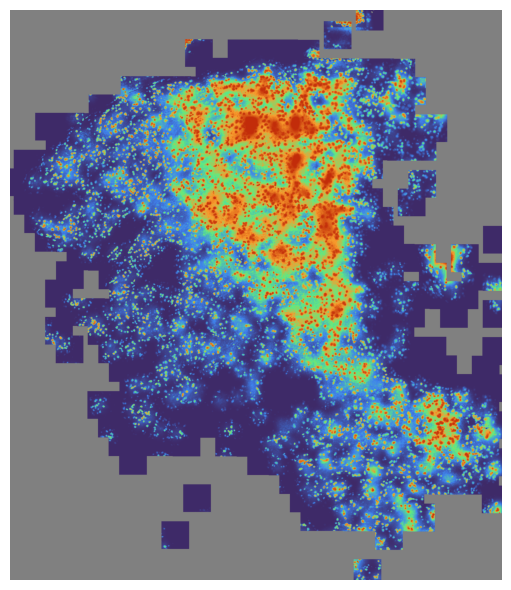

In [9]:
mapper.visualize(mouse_cortex_refine, use_score='SpaHDmap', index=1)

*** Visualizing and saving the embeddings of SpaHDmap... ***


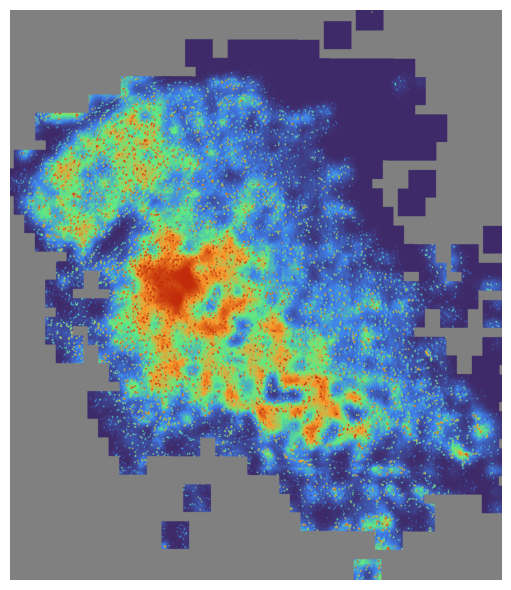

In [11]:
mapper.visualize(mouse_cortex_refine, use_score='SpaHDmap', index=7)

*** Performing clustering using SpaHDmap scores... ***
Found 3 clusters for section mouse_cortex
*** Visualizing clustering results for SpaHDmap... ***


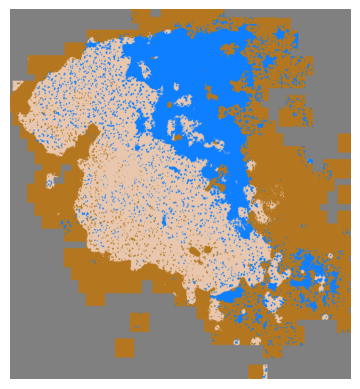

In [21]:
mapper.cluster(use_score='SpaHDmap', resolution=0.2, show=True)